In [1]:
# cell_labels = annotations_df.Merged_final.to_numpy()
# cell_labels

# Y = annotations_df.x.to_numpy() // 2
# X = annotations_df.y.to_numpy() // 2
# ID = annotations_df.unique_region.to_numpy()

# identifier = np.stack((X, Y, ID), axis=1)

# sample_ids = list(sample_dict.keys())
# mask = np.isin(identifier[:, 2], sample_ids)
# _id = identifier[mask]
# _cell_labels = cell_labels[mask]
# _id.shape, _cell_labels.shape

In [2]:
import numpy as np

def match_masks_to_annotations(masks, X, Y, cell_labels, dim_min=0):
    """
    Match segmentation masks to annotations based on spatial overlap (vectorized).
    
    Parameters:
    - masks: 2D array of segmentation masks
    - X: array of x-coordinates for annotations
    - Y: array of y-coordinates for annotations
    - cell_labels: array of labels for each annotation
    - dim_min: minimum dimension offset (default 0)
    
    Returns:
    - matched_masks: filtered mask array
    - matched_labels: corresponding labels
    - multi_annotation_count: number of masks with multiple annotations
    """
    # Stack X and Y coordinates and adjust to mask space
    coords = np.column_stack([X, Y])
    coords = (coords - dim_min).astype(int)
    
    # Clip coordinates to valid range
    coords[:, 0] = np.clip(coords[:, 0], 0, masks.shape[0] - 1)
    coords[:, 1] = np.clip(coords[:, 1], 0, masks.shape[1] - 1)
    
    # Get mask ID for each annotation point (vectorized lookup)
    mask_ids_at_points = masks[coords[:, 0], coords[:, 1]]
    
    # Filter out annotations that landed on background (mask_id == 0)
    valid_mask = mask_ids_at_points > 0
    valid_mask_ids = mask_ids_at_points[valid_mask]
    valid_labels = cell_labels[valid_mask]
    
    # Find unique mask IDs and get first annotation for each
    unique_masks, first_indices, counts = np.unique(
        valid_mask_ids, return_index=True, return_counts=True
    )
    
    # Count masks with multiple annotations
    multi_annotation_count = np.sum(counts > 1)
    
    # Get first label for each mask
    matched_labels = valid_labels[first_indices]
    
    # Create remapping: old_mask_id -> new_mask_id
    remap = np.zeros(masks.max() + 1, dtype=int)
    remap[unique_masks] = np.arange(1, len(unique_masks) + 1)
    
    # Apply remapping to create new masks (vectorized)
    matched_masks = remap[masks]
    
    print(f"Matched {len(matched_labels)} masks to annotations")
    print(f"Masks with multiple annotations: {multi_annotation_count}")
    
    return matched_masks, matched_labels.tolist(), multi_annotation_count

In [3]:
from pathlib import Path
from pathlib import Path
from tifffile import imread
from tqdm import tqdm
import pandas as pd
import numpy as np
from CellPatchExtraction_package.CellPatchExtraction import segment_image

imaging_data_folder = Path('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data')
dataset_name = 'CODEX_DLBCL2'

dataset_folder = imaging_data_folder / dataset_name
dataset_folder.mkdir(exist_ok=True)

target_images_folder = dataset_folder / 'images'
target_images_folder.mkdir(exist_ok=True)

target_masks_folder = dataset_folder / 'masks'
target_masks_folder.mkdir(exist_ok=True)

/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. Please upgrade your Python version,
    and then update google-auth.
    
  warnings.warn(eol_message.format("3.9"), FutureWarning)
/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/google/oauth2/__init__.py:40: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. P

In [4]:
base = Path('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DLBCL')

annotations = pd.read_csv(base / 'cells_annotation.csv')
region = [r[-3:] for r in annotations.unique_region.values]
patient_id = annotations.PatientID.values
patient_id_region = ["_".join([pid, r]) for pid, r in zip(patient_id, region)]
annotations['PatientID_Region'] = patient_id_region

marker_list = pd.read_excel('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DLBCL/marker_info.xlsx', sheet_name='Supplementary Table 6')
markers = marker_list.Target.tolist()[:-1]
markers.append('DNA')

samples = list(base.glob('*.tif'))
samples = [s for s in samples if'191_4' in s.stem]
print(len(samples))

sample_dict = dict()
for i, sample in enumerate(tqdm(samples)):

    sample_id = sample.stem[:-12]
    sample_id = sample_id[:-7] + sample_id[-6:]
    
    sample_name = annotations[annotations.unique_region == sample_id].PatientID_Region.values[0]
    print(sample_name)
        
    marker_image_dict = dict()
    image = imread(sample)
    
    nuclear = np.array([i[0] for i in image]).mean(axis=0)
    
    stack = np.concatenate([image[:, 1], nuclear[None, :]])
    stack = stack / 65535.
    
    for marker, im in zip(markers, stack):
        marker_image_dict[marker] = im
        
    marker_image_dict['segmentation'] = None
        
    sample_dict[sample_name] = marker_image_dict

4


  0%|          | 0/4 [00:00<?, ?it/s]

LN0251_007


 25%|██▌       | 1/4 [00:40<02:02, 40.97s/it]

LN0265_002


 50%|█████     | 2/4 [01:21<01:21, 40.97s/it]

LN0265_003


 75%|███████▌  | 3/4 [02:02<00:40, 40.95s/it]

LN0251_006


100%|██████████| 4/4 [02:43<00:00, 40.95s/it]


In [5]:
annotations_ = annotations[annotations.PatientID_Region.isin(list(sample_dict.keys()))]
annotations_.x = annotations_.x // 2
annotations_.y = annotations_.y // 2
annotations_

/tmp/ipykernel_25259/2266528989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_.x = annotations_.x // 2
/tmp/ipykernel_25259/2266528989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_.y = annotations_.y // 2


unique_cell_id     x     y unique_region PatientID   Merged_final  \
3441835       191_4_2_1  4184  3295   191_4reg002    LN0265              B   
3441836       191_4_2_2  1751  3638   191_4reg002    LN0265              B   
3441837       191_4_2_3  3048  2030   191_4reg002    LN0265              B   
3441838       191_4_2_4   395  2666   191_4reg002    LN0265             na   
3441839       191_4_2_5  1295  3553   191_4reg002    LN0265  Stromal cells   
...                 ...   ...   ...           ...       ...            ...   
4299631  191_4_7_165510   269  2723   191_4reg007    LN0251              B   
4299632  191_4_7_165511  4846  1159   191_4reg007    LN0251           Treg   
4299633  191_4_7_165512  3648  2072   191_4reg007    LN0251              B   
4299634  191_4_7_165513  2485   511   191_4reg007    LN0251           CD4T   
4299635  191_4_7_165514  3755  3602   191_4reg007    LN0251              B   

        PatientID_Region  
3441835       LN0265_002  
3441836       LN0265_002  
3441837       LN0265_002  
3441838       LN0265_002  
3441839       LN0265_002  
...                  ...  
4299631       LN0251_007  
4299632       LN0251_007  
4299633       LN0251_007  
4299634       LN0251_007  
4299635       LN0251_007  

[639706 rows x 7 columns]

[2834 1855 1948  993 2411  701 2187 1211 2198 2818] [ 871  771 2665 2120 3925 2727 4210 1458 1897 3531] ['Treg' 'na' 'B' 'B' 'na' 'B' 'Macro' 'B' 'NKT' 'Stromal cells'] 164496


more than 65535 masks in image, masks returned as np.uint32


Done segmenting!
158457


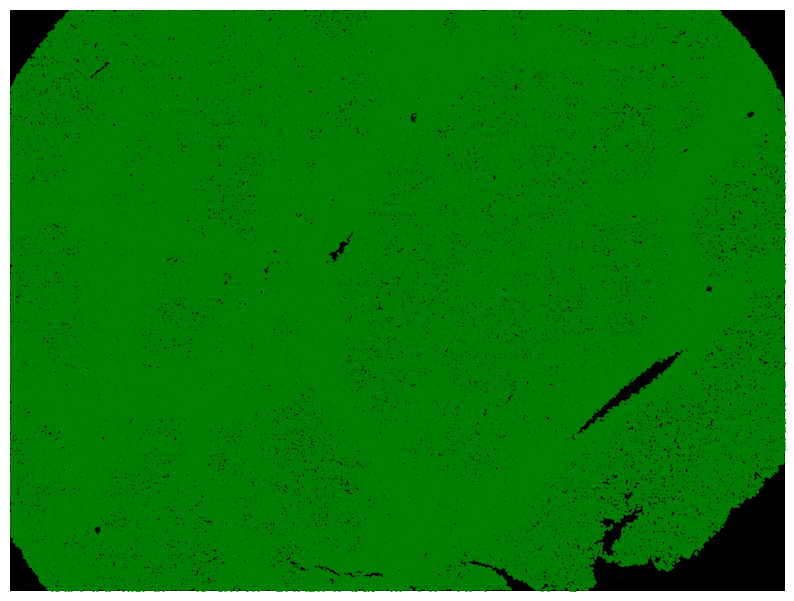

Matched 139183 masks to annotations
Masks with multiple annotations: 14225
139184


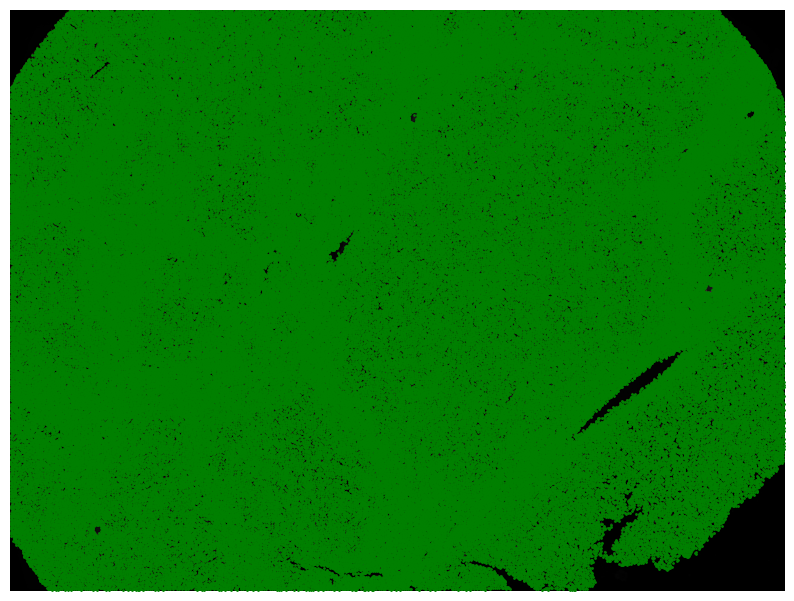

139183 139183 139183 139183
[3295 3638 2030 2666 3553 2534 1570 3295 3303  138] [4184 1751 3048  395 1295 3540  499  797 4313 4389] ['B' 'B' 'B' 'na' 'Stromal cells' 'Stromal cells' 'TTOX_exh' 'CD4T' 'DC'
 'B'] 167286


more than 65535 masks in image, masks returned as np.uint32


Done segmenting!
154928


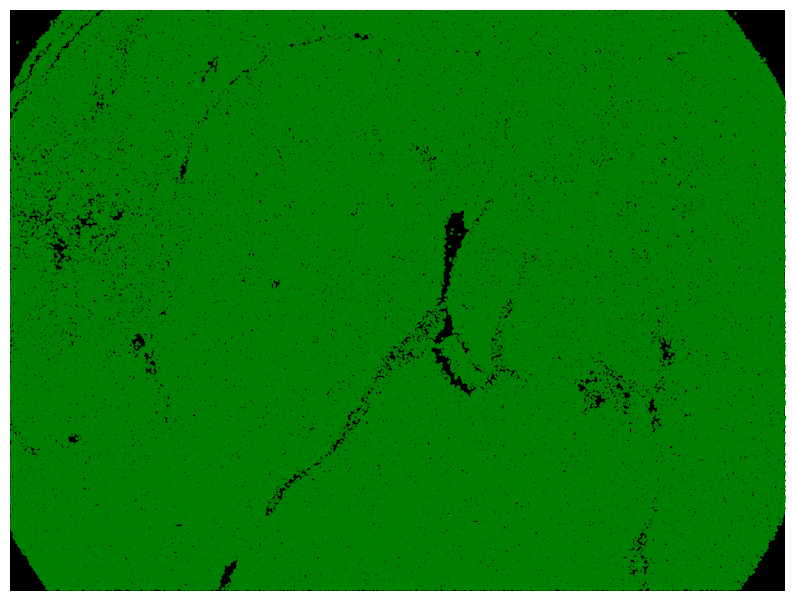

Matched 143122 masks to annotations
Masks with multiple annotations: 11811
143123


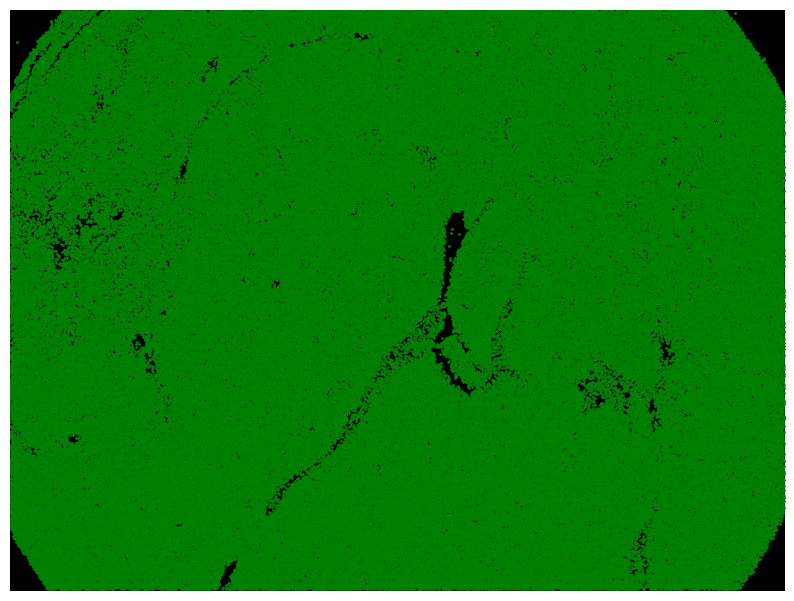

143122 143122 143122 143122
[ 964 1112  626 3489 3260 1768  340 1476 2557  336] [1497 1350  344 4722 4786 1488  710  996 1994 3937] ['B' 'B' 'B' 'Macro' 'TTOX_exh' 'B' 'B' 'B' 'B' 'B'] 146907


more than 65535 masks in image, masks returned as np.uint32


Done segmenting!
142620


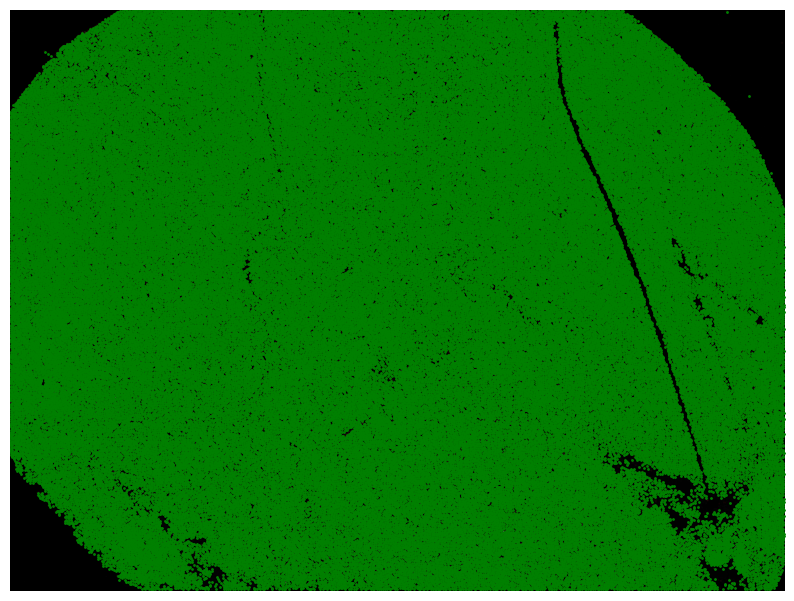

Matched 129117 masks to annotations
Masks with multiple annotations: 9113
129118


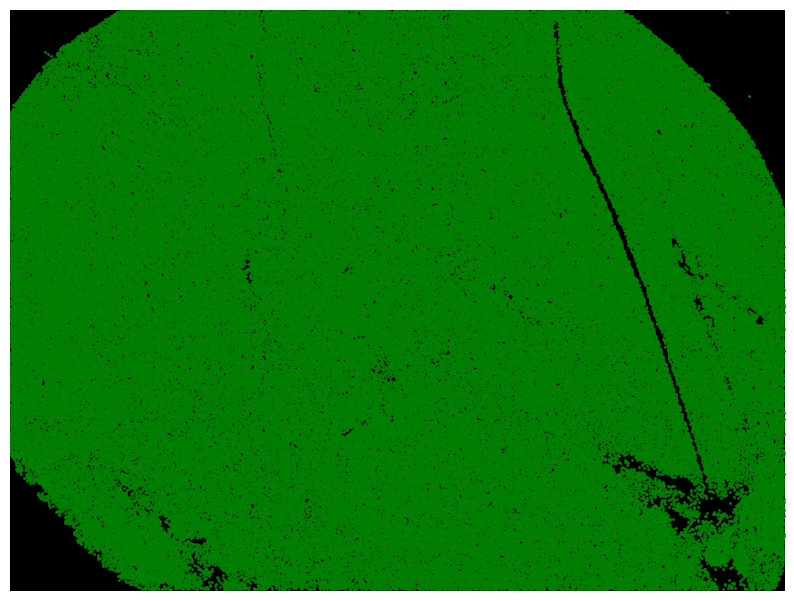

129117 129117 129117 129117
[ 339 2151 1593 3232  309 3062  951 2609 3077 1733] [4616 1043  495 3449 2248 2390 1690 3314 3565   30] ['B' 'Macro' 'na' 'TTOX_exh' 'B' 'B' 'B' 'B' 'Macro' 'B'] 161017


more than 65535 masks in image, masks returned as np.uint32


Done segmenting!
158020


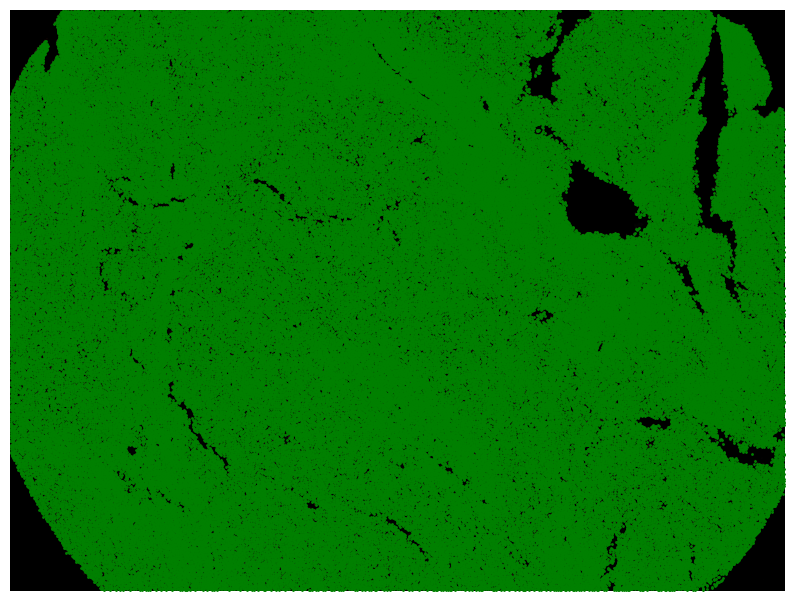

Matched 137440 masks to annotations
Masks with multiple annotations: 12780
137441


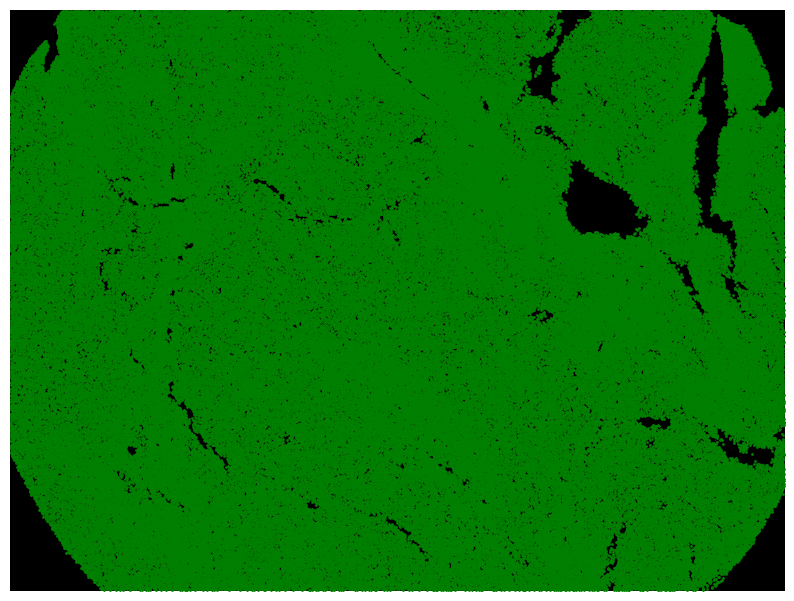

137440 137440 137440 137440


In [6]:
import torch
from cellplot_package.cellplot.segmentation import contoure_seg, rand_col_seg
import matplotlib.pyplot as plt
from scipy import ndimage
import tifffile

all_annotations = []
marker_list = None
for sample, images_dict in sample_dict.items():
    
    sample_replaced = sample.replace('_', '-')
    
    dim_min = 0
    dim_max = np.inf
    
    mask = (annotations_.PatientID_Region == sample) #& (annotations_.x > dim_min) & (annotations_.x < dim_max) & (annotations_.y > dim_min) & (annotations_.y < dim_max)
    DIM1, DIM2 = annotations_.y[mask].values, annotations_.x[mask].values
    cell_labels = annotations_.Merged_final[mask].values
    
    print(DIM1[:10], DIM2[:10], cell_labels[:10], len(cell_labels))
    
    nuclear = images_dict['DNA']
    
    masks, image = segment_image(
        nuclear, #[dim_min:dim_max, dim_min:dim_max], 
        model='CP_TU_MORE', 
        device=torch.device('cuda:0'), 
        dilate_masks=False, 
        cellpose_kwargs={
            'diameter': 13,
            'cellprob_threshold': 0,
            'flow_threshold': 0
        })
    
    print(len(np.unique(masks)))
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.clip(np.stack([image]*3).transpose(1,2,0) + 0.2 * contoure_seg(masks, ret_rgb=True, dilate=False), 0, 1))
    plt.scatter(DIM2-dim_min, DIM1-dim_min, s=1, color='green')
    plt.axis('off')
    plt.show()
    
    # Use it in your loop:
    matched_masks, matched_labels, multi_count = match_masks_to_annotations(
        masks, DIM1, DIM2, cell_labels, dim_min
    )
    
    print(len(np.unique(matched_masks)))
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.clip(np.stack([image]*3).transpose(1,2,0) + 0.2 * contoure_seg(matched_masks, ret_rgb=True, dilate=False), 0, 1))
    plt.scatter(DIM2-dim_min, DIM1-dim_min, s=1, color='green')
    plt.axis('off')
    plt.show()
    
    index = np.unique(matched_masks)
    index = index[index != 0]
    
    centroids = np.array(ndimage.center_of_mass(matched_masks, labels=matched_masks, index=index)).round().astype(int)
    
    mask_values = matched_masks[centroids[:, 0], centroids[:, 1]]
    print(len(index), len(centroids), len(mask_values), len(matched_labels))
    
    image_annotations = dict(
        DIM1=centroids[:, 0],
        DIM2=centroids[:, 1],
        SampleID=sample_replaced,
        annotation=matched_labels,
        mask_value=mask_values
    ) 
    
    all_annotations.append(pd.DataFrame(image_annotations))
    
    if marker_list is None:
        marker_list = [m for m in images_dict.keys() if m not in ["segmentation", 'Blank']]
        marker_list = list(marker_list)

    images = np.array([images_dict[m] for m in marker_list]).transpose(1,2,0)
    
    tifffile.imwrite(target_images_folder / f'{sample_replaced}_image.tif', images)
    tifffile.imwrite(target_masks_folder / f'{sample_replaced}_masks.tif', matched_masks)

combined_annotations = pd.concat(all_annotations, ignore_index=True)
combined_annotations.to_csv(dataset_folder / 'annotations.csv', index=False)

marker_names = pd.DataFrame(marker_list, columns=['Label'])
marker_names.to_csv(dataset_folder / 'marker_names.csv')

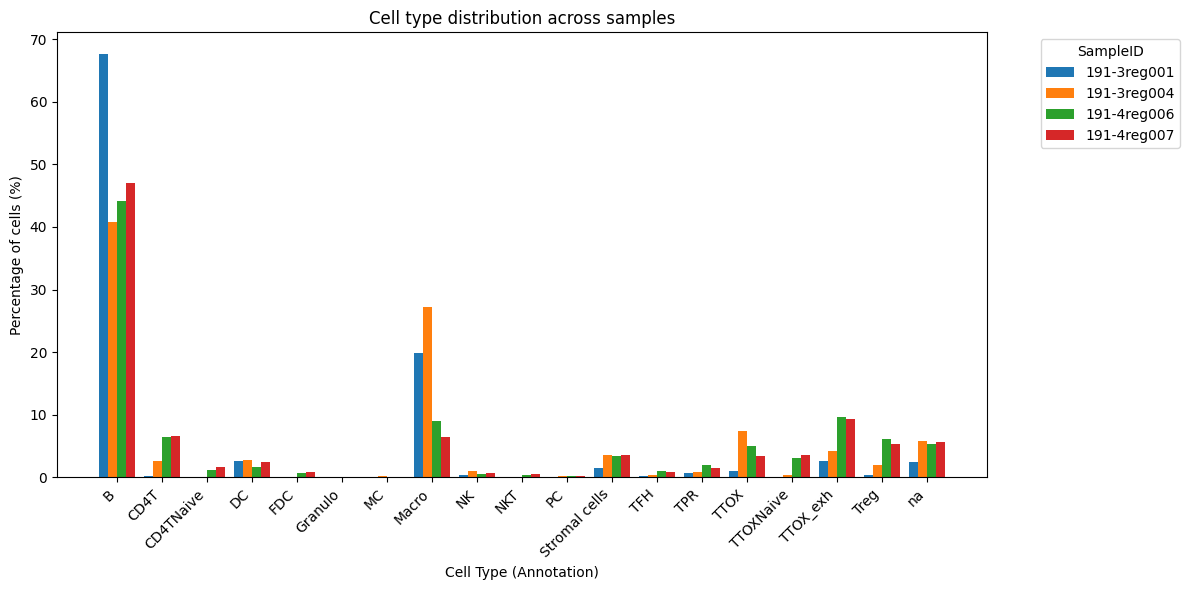

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# df has columns 'SampleID', 'annotation', etc.
annotations = pd.read_csv('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/CODEX_DLBCL/annotations.csv')

# 1. Compute counts per SampleID and annotation
annotation_counts = annotations.groupby(['SampleID', 'annotation']).size().unstack(fill_value=0)

# 2. Convert to percentages per SampleID
annotation_percent = annotation_counts.div(annotation_counts.sum(axis=1), axis=0) * 100

# 3. Set up the plot
annotations = annotation_percent.columns
sample_ids = annotation_percent.index
n_samples = len(sample_ids)
n_annotations = len(annotations)

fig, ax = plt.subplots(figsize=(12,6))

# Width of each bar
bar_width = 0.8 / n_samples

# X locations for each annotation cluster
x = np.arange(n_annotations)

# Plot bars per sample
for i, sample_id in enumerate(sample_ids):
    ax.bar(x + i*bar_width,
           annotation_percent.loc[sample_id, :],
           width=bar_width,
           label=sample_id)

# X-axis labels
ax.set_xticks(x + bar_width*(n_samples-1)/2)
ax.set_xticklabels(annotations, rotation=45, ha='right')

ax.set_ylabel('Percentage of cells (%)')
ax.set_xlabel('Cell Type (Annotation)')
ax.set_title('Cell type distribution across samples')
ax.legend(title='SampleID', bbox_to_anchor=(1.05, 1), loc='upper left')

# ax.set_ylim(0, 25)

plt.tight_layout()
plt.show()